# Практическое задание 2. Диффузионные модели


## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи).

Сдавать задание после указанного жёсткого срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи !!ВАЖНО!!!
Задания сдаются через систему google classroom. Посылка должна содержать:
* Ноутбук ddpm_hw_bmmo-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## В этом задании необходимо будет дореализовать ключевые формулы для обучения дискретной [ddpm](https://arxiv.org/pdf/2006.11239.pdf).  


---
Для выполнения домашнего задания достаточно использовать Google Colab.


In [1]:
!python3 -V
import torch


print(f'torch.__version__: {torch.__version__}')

Python 3.10.11
torch.__version__: 2.4.1


In [2]:
!pip3 install wandb torch_ema denoising_diffusion_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 516.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 176.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 268.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 101.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 642.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 199.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 86.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 148.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 135.3 kB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
import numpy as np
import random

def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_global_seed(42)

## Dataset

In [4]:
import numpy as np

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from typing import Generator, Tuple, Dict, Optional, Union
from torch import Tensor
from cv2 import resize


def preprocess_image(image: "PIL.Image") -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = resize(image, (32, 32))
    return np.array(image, dtype=np.float32) / 127.5 - 1


def postprocess_image(image: torch.Tensor) -> torch.Tensor:
    # convert values to [0; 255]
    image = image.cpu().detach()
    image = (image + 1) * 127.5
    image = torch.clip(image, 0, 255)
    return image


class MnistDataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        self.mnist = MNIST(
            'data',
            train=train,
            download=True
        )

    def __len__(self) -> int:
        return len(self.mnist)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.mnist[index]
        image = preprocess_image(image)
        target = int(target)
        return {
            "images": Tensor(image)[None],
            "targets": target
        }

In [5]:
def dict_to_device(dct: Dict[str, Tensor], device: torch.device) -> Dict[str, Tensor]:
    return {k: v.to(device) for k, v in dct.items()}


def get_train_images_generator(
    batch_size: int = 128,
    num_workers: int = 0,
    shuffle: bool = True,
    drop_last: bool = True
) -> Generator[Dict[str, Tensor], None, None]:
    dataset = MnistDataset(train=True)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=drop_last
    )
    while True:
        yield from loader

In [7]:
# requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [8]:
def check_generator(batch_size: int = 128):
    generator = get_train_images_generator(batch_size)
    batch_dict = next(generator)
    assert(batch_dict['images'].shape == (batch_size, 1, 32, 32), batch_dict['images'].shape)
    assert(batch_dict['targets'].shape == (batch_size,), batch_dict['targets'].shape)

check_generator(131)

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_11718/2113533935.py:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(batch_dict['images'].shape == (batch_size, 1, 32, 32), batch_dict['images'].shape)
/var/folders/yh/4jky_nln065c8nrzc6phgjjdt0k6bs/T/ipykernel_11718/2113533935.py:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(batch_dict['targets'].shape == (batch_size,), batch_dict['targets'].shape)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 9912422/9912422 [00:19<00:00, 501947.04it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 12] Cannot allocate memory>



100%|██████████████████████████████████| 28881/28881 [00:01<00:00, 28400.08it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 1648877/1648877 [00:02<00:00, 586359.33it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████| 4542/4542 [00:00<00:00, 379454.81it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## DDPM's dynamic, 5 pts



В `get_coeffs_primities` (2 pts) необходимо в возвращаеый словарь добавить рассчет коэффицентов, при помощи которых вы сможете реализовать семплирование из распределений $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$.

Например:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha_t} = \prod_{t=1}^{T} \alpha_t$
- $\sqrt{\bar{\alpha_t}}$
- ...
- любые коэффиценты, которые помогут вам рассчитать коэффиценты в $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$

`extract_values_from_times` - по батчу с целочислненными временами выдает батч коэфиицентов в нужном шейпе для перемножения с батчом картинок


In [64]:
from torch import nn


def get_coeffs_primitives(
    T: int = 1000,
    beta_min: float = 1e-4,
    beta_max: float = 2e-2,
) -> Dict[str, Tensor]:
    """
    output: Dict[str, Tensor]
      {
        "a": b
      }
    ---
    b.shape == (T,)
    """
    betas = torch.linspace(beta_min, beta_max, T).float()
    alphas = 1 - betas

    sqrt_alphas = torch.sqrt(alphas)
    alphas_hat = torch.cumprod(alphas, dim=0)

    alphas_hat_prev = torch.cat([torch.FloatTensor([1.]), alphas_hat[:-1]])

    # YOUR CODE GOES HERE
    sqrt_alphas_hat = torch.sqrt(alphas_hat_prev)
    sqrt_1m_alphas_hat = torch.sqrt(1 - sqrt_alphas_hat)
    return {
        "betas": betas,
        "alphas": alphas,
        "sqrt_alphas_hat": sqrt_alphas_hat,
        "sqrt_1m_alphas_hat": sqrt_1m_alphas_hat,
        "alphas_hat": alphas_hat,
        # "_1m"
    }


def extract_values_from_times(values: Tensor, times: torch.LongTensor) -> Tensor:
    values = values[times]
    return values[:, None, None, None]


`DDPMDynamic`: (3 pts)
- `__init__` - получаем коэффиценты, добавляем их в класс, как атрибуты, чтобы доставать их по имени без использования словаря
- `sample_from_posterior_q(x_t: FloatTensor, x_0: FloatTensor, t: LongTensor)` - $ x_{t-1} \sim q(x_{t-1} | x_{t}, x_0) $
- `forward` - $ x_{t} \sim q(x_t | x_0) $

`forward` - $ x_{t} \sim q(x_t | x_0) $

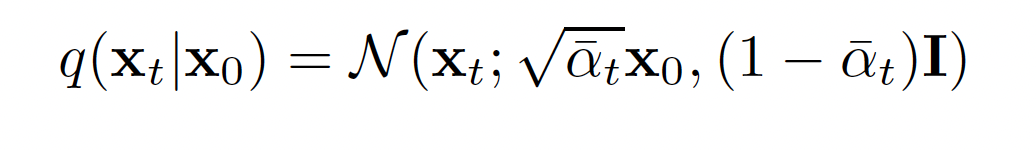

sample_from_posterior_q $x_{t-1} \sim q(x_{t-1} | x_{t}, x_0)$

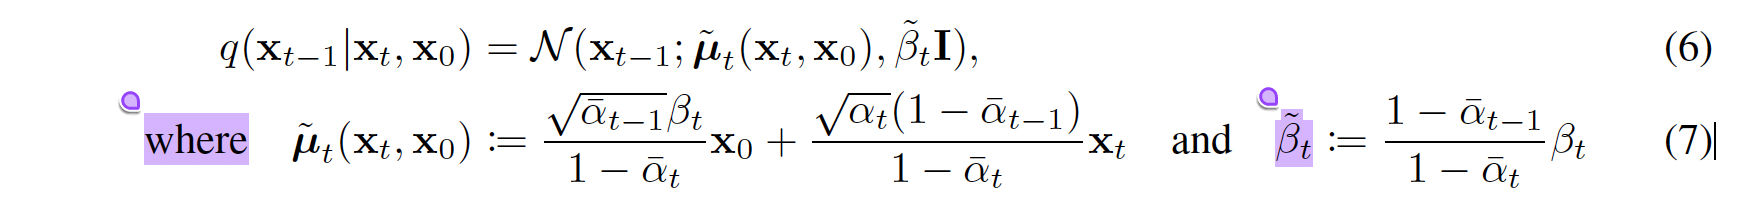

In [65]:
class DDPMDynamic(nn.Module):
    def __init__(
        self,
        T: int = 1000,
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
    ):
        super().__init__()
        self.T = T

        coeffs_primitives = get_coeffs_primitives(T, beta_min, beta_max)

        for name, tensor in coeffs_primitives.items():
            self.register_buffer(name, tensor)

    def sample_time_on_device(self, batch_size: int = 1, device: torch.device = torch.device('cpu')):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def sample_from_posterior_q(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        
        beta_t = extract_values_from_times(self.betas, t)
        alpha_hat_t = extract_values_from_times(self.alphas_hat, t)
        alpha_hat_tm1 = extract_values_from_times(self.alphas_hat, t - 1)
        sqrt_alpha_hat_t = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_alpha_hat_tm1 = extract_values_from_times(self.sqrt_alphas_hat, t - 1)

        mu = (
            sqrt_alpha_hat_tm1 * beta_t / (1 - alpha_hat_t) * x_0 + 
            sqrt_alpha_hat_t * (1 - alpha_hat_tm1) / (1 - alpha_hat_t) * x_t
        )

        beta_t_tilda = (1 - alpha_hat_tm1) / (1 - alpha_hat_t) * beta_t

        q_tm1_st_xt_x0 = mu + torch.rand_like(x_0) * torch.sqrt(beta_t_tilda)

        return q_tm1_st_xt_x0

    def get_x_zero(
        self,
        x_t: Tensor,
        eps: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        x_0 = (x_t - sqrt_1m_alphas_hat * eps) / sqrt_alphas_hat
        return x_0

    def forward(self, batch: Dict[str, Tensor]) -> Dict[str, Tensor]:
        """
            Dict:
                x_0 - clean_image
                t - time (int \in [0; T - 1])
                eps - Optional[corresponding noise]
        Returns:
            Dict:
                x_t - noised_sample
                eps - corresponding noise
        """
        x_0 = batch['x_0']
        t = batch['time']
        eps = batch.get('eps', None)

        # YOUR CODE GOES HERE

        # по статье
        # x_t = torch.normal(
        #     mean=extract_values_from_times(self.sqrt_alphas_hat, t) * x_0,
        #     std=(1 - extract_values_from_times(self.alphas_hat, t)) * torch.ones_like(x_0)
        # )
        
        sqrt_alpha_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)
        
        eps = eps if eps else torch.rand_like(x_0) * sqrt_1m_alphas_hat
        x_t = sqrt_alpha_hat * x_0 + eps

        return {
            "x_t": x_t,
            "eps": eps
        }


In [66]:
def check_ddpm_dynamic():
    dynamic = DDPMDynamic()
    device = torch.device('cuda:0')
    # device = torch.device('cpu')
    dynamic.to(device)
    times = dynamic.sample_time_on_device(10, device)
    assert times.device == device, f'{times.device}, {device}'
    assert times.shape == (10,)

check_ddpm_dynamic()

AssertionError: Torch not compiled with CUDA enabled

### `Sampler`/DDPM's cycle: (1.5 pts)
- `single_step` - необходимо просемплировать $x_{t-1} \sim p(x_{t-1}|x_t)$
- `sample` - весь процесс обхода по марковской цепочки семплирования

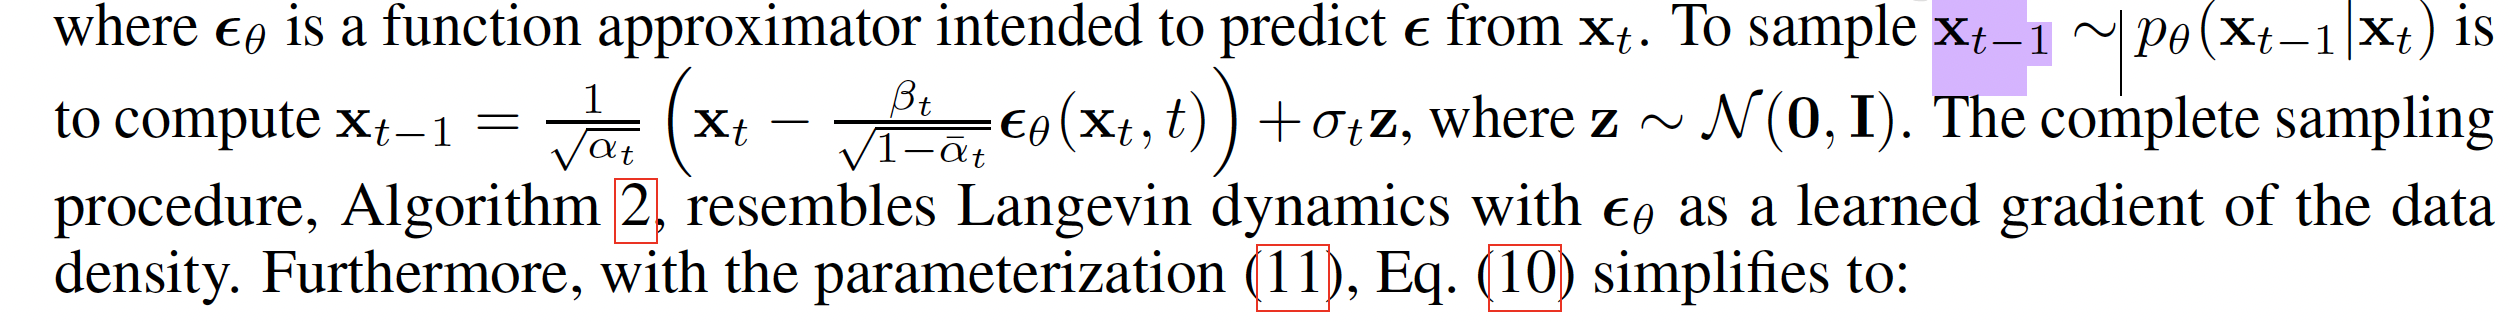

In [51]:
from tqdm.auto import trange


class Sampler(nn.Module):
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic
    ):
        super().__init__()
        ddpm.eval()
        self.ddpm = ddpm
        self.dynamic = dynamic

    @torch.no_grad()
    def single_step(self, x_t, t):
        return self.dynamic.sample_from_posterior_q(x_t, x_t, t)

    @torch.no_grad()
    def sample(
        self,
        shape: Tuple[int, int, int, int],
        device: torch.device = torch.device('cpu'),
        verbose: bool = False
    ) -> Tensor:
        self.ddpm.eval()
        x_t = torch.randn(shape, device=device)
        batch_size = shape[0]

        bar = trange if verbose else range
        for t in bar(self.dynamic.T - 1, -1, -1):
            t_tensor = torch.ones(batch_size, dtype=torch.int64, device=device) * t
            x_t = self.single_step(x_t, t_tensor)
        return x_t


### При помощи примитивов сверху реализовать обучение ddpm.


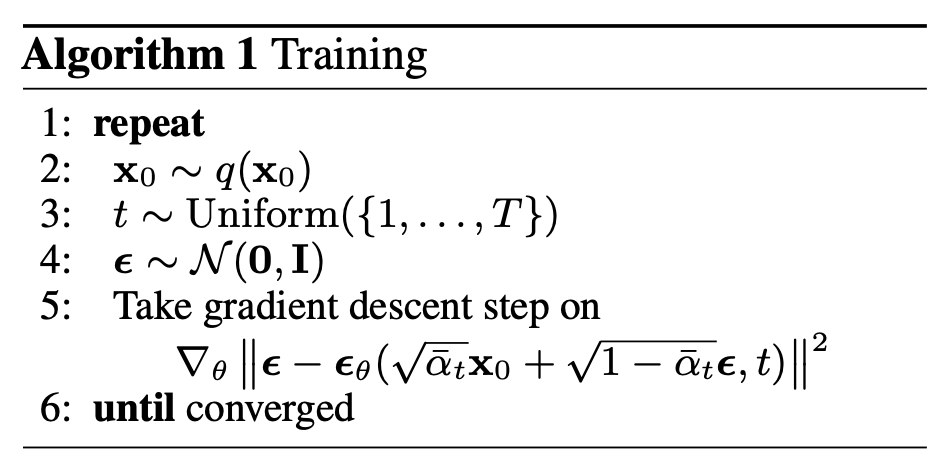


`DiffusionTrainer`: (1.5 pts)
- `calc_loss(clean_images: FloatTensor)` - необходимо внутри метода просемплировать время, далее просемплировать $x_t$, обработать батч, рассчитать лосс для обучения

In [67]:
from torch_ema import ExponentialMovingAverage
import wandb
import math
import torchvision


class DiffusionTrainer:
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        device: torch.device = torch.device('cpu')
    ):
        self.ddpm = ddpm
        self.dynamic = dynamic

        self.dynamic.to(device)
        self.ddpm.to(device)

        self.sampler = Sampler(ddpm, dynamic)
        self.sampler.to(device)

        self.ema = ExponentialMovingAverage(ddpm.parameters(), decay=0.999)

        self.device = device


        self.optimizer = torch.optim.AdamW(
            self.ddpm.parameters(),
            lr=2e-4,
            weight_decay=1e-2
        )

        self.step = 0

    def switch_to_ema(self) -> None:
        self.ema.store(self.ddpm.parameters())
        self.ema.copy_to(self.ddpm.parameters())

    def switch_back_from_ema(self) -> None:
        self.ema.restore(self.ddpm.parameters())

    def calc_loss(self, x_0: torch.Tensor) -> torch.Tensor:
        # YOUR CODE GOES HERE
        ts = self.dynamic.sample_time_on_device(
            batch_size=x_0.size()[0],
            device=self.device
        )
        batch = {'images': x_0, 'time': ts}
        dynamic_output = self.dynamic(batch)
        x_t = dynamic_output['x_t']
        score = self.ddpm(x_0) ## TO DO: ? 
        loss - torch.mean((x_t - x_0) ** 2 * score)
        return loss

    def log_metric(self, metric_name: str, loader_name: str, value: Union[float, torch.Tensor, wandb.Image]):
        wandb.log({f'{metric_name}/{loader_name}': value}, step=self.step)

    def optimizer_logic(self, loss: torch.Tensor) -> None:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.ema.update(self.ddpm.parameters())

    def train(
            self,
            train_generator: Generator[Dict[str, Tensor], None, None],
            total_iters: int = 1000,
            project_name: str = 'discrete_time_ddpm',
            experiment_name: str = 'mnist_baseline'
        ) -> None:
        session = wandb.init(project=project_name, name=experiment_name)

        self.ddpm.train()

        for iter_idx in trange(1, 1 + total_iters):
            self.step = iter_idx

            batch = next(train_generator)
            batch = dict_to_device(batch, device=self.device)

            loss = self.calc_loss(x_0=batch['images'])
            self.log_metric('mse', 'train', loss)

            self.optimizer_logic(loss)

            if iter_idx % 1000 == 0:
                self.snapshot()

        self.ddpm.eval()
        self.switch_to_ema()

        session.finish()

    @torch.no_grad()
    def sample_images(
            self, batch_size: int,
            verbose: bool = False
    ) -> torch.Tensor:
        x_pred = self.sampler.sample((batch_size, 1, 32, 32), self.device, verbose)
        x_pred = postprocess_image(x_pred)
        return x_pred

    @torch.no_grad()
    def snapshot(self) -> None:
        prev_mode = self.ddpm.training

        self.ddpm.eval()
        self.switch_to_ema()

        images = self.sample_images(100).cpu()
        nrow = 10
        grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)
        self.log_metric('images', 'from_noise', wandb.Image(grid))

        self.switch_back_from_ema()
        self.ddpm.train(prev_mode)

In [53]:
from denoising_diffusion_pytorch import Unet

set_global_seed(42)

ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 4),
    channels=1,
    flash_attn=True
)

In [56]:
device = torch.device('cuda:0')

In [57]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)

In [58]:
generator = get_train_images_generator(128)

In [59]:
trainer.train(
    generator,
    total_iters=5000
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

Вы обучили большую модель, самое важное ее сохранить и не потерять!!!

In [ ]:
trainer.switch_to_ema()
torch.save(ddpm.state_dict(), "./pretrained_ddpm_checkpoint.pth")

#### Безусловная генерация (неплохих картинок - 1 pts)

In [ ]:
from matplotlib import pyplot as plt
import math


def sample_images(
    sampler: Sampler, batch_size: int == 100,
    device = torch.device('cpu'),
    verbose: bool = True
):
    images = sampler.sample((batch_size, 1, 32, 32), device, True)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

grid = sample_images(trainer.sampler, 100, trainer.device)

plt.imshow(grid)

### Опишите ваши выводы/результаты: (1 pts)
-
-
-

# Оценка качества (2 pts) 

Для оценки качества часто используют метрику FID (Freche Inception Distance), чем ниже FID между двумя наборами изображений, тем более они похожи. На практике мерят FID между выборками одинакового размера, а в качестве эталонной выборки используют обучающую. Вам необходимо посчитать FID для 200, 1_000, 5_000, 8_000 и 10_000 изображений.

Эталоном считается FID посчитанный на выборках размера 50_000 изображений, но это слишком долго в рамках учебной задачи.

Идейно FID равен расстоянию Фреше (расстоянию между двумя нормальными распределениями) в латентном пространстве хорошего классификатора (Inception V3).

Для подсчета метрики, можно использовать [библиотечную реализацию](https://github.com/mseitzer/pytorch-fid)

**Подсказка**

Вы можете сразу сгенерировать 10_000 изображений, а потом аккуратно брать нужное количество для экономии времени.


In [ ]:
!pip install pytorch-fid

In [ ]:
import os
import PIL

from tqdm import tqdm
from pytorch_fid.fid_score import calculate_fid_given_paths

In [ ]:
set_global_seed(42)

ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 4),
    channels=1,
    flash_attn=True
)

In [ ]:
checkpoint = torch.load("./pretrained_ddpm_checkpoint.pth")

ddpm.load_state_dict(checkpoint)
ddpm.eval()

In [ ]:
device = torch.device('cuda:0')

In [ ]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)

In [ ]:
@torch.no_grad()
def gen_imgs(
    sampler: Sampler, folder: str,  
    device = torch.device('cuda:0'), 
    count: int == 10_000, batch_size: int = 100, seed: int = 42
):
    
    set_global_seed(seed)
    os.makedirs(folder, exist_ok=True)
    iter_num = count // batch_size + int(count % batch_size > 0)
    
    for _ in tqdm(range(iter_num))
    
        already_sampled = len(os.listdir(folder))
        bs = min(bs, count - already_sampled)

        images = sampler.sample((bs, 1, 32, 32), device, True)
        images = postprocess_image(images)
        images = images.cpu().permute(0, 2, 3, 1).numpy().astype('uint8')

        for i in range(images.shape[0]):
            index = already_sampled + i
            
            file_name = os.path.join(folder, f'img_{index:05d}.png')
            PIL.Image.fromarray(images[i, :, :, 0], 'L').save(file_name)

In [ ]:
def extract_dataset(folder: str, count: int = 10_000):
    
    os.makedirs(folder, exist_ok=True)
    data = MnistDataset()
    
    for i in tqdm(range(count)):
        img = data[i]['images']
        img = postprocess_image(img)
        img = img.cpu().permute(1, 2, 0).numpy().astype('uint8')

        file_name = os.path.join(folder, f'img_{i:05d}.png')
        PIL.Image.fromarray(img[:, :, 0], 'L').save(file_name)

In [ ]:
extract_dataset("./mnist_data_img")

In [ ]:
# Долгая функция

gen_imgs(trainer.sampler, "./mnist_gen_img")

In [ ]:
path_dataset = ...
path_output  = ...


fid = calculate_fid_given_paths(
        [path_dataset, path_output],
        batch_size=100, 
        device=device, 
        dims=2048, 
        num_workers=12
    )

Нарисуйте график значения FID в зависимости от размера выборок. Учтите, что для корректной работы выборки должны быть одинакового размера. Какие выводы вы можете сделать?